## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Step by Step process for debugging and illustration

## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from Line import *
import random
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2]= np.mgrid[0:9,0:6].T.reshape(-1,2)



# Arrays to store object points and image points from all the images.
objpoints = []# 3d points in real world space
imgpoints = []# 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

test_imgs = []

# camera calibration results
cameraMatrix = None
calibrate = None


# Step through the list and search for chessboard corners
for i, fname in enumerate(tqdm(images)):
    img = cv2.imread(fname)
    test_imgs.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# calculate the camera matrix and calibration parameters using all the corners found in the 20 calibration images
retval, cameraMatrix, calibrate, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



     

100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


## Step 2. Calculate the Distortion and Undistort the Images

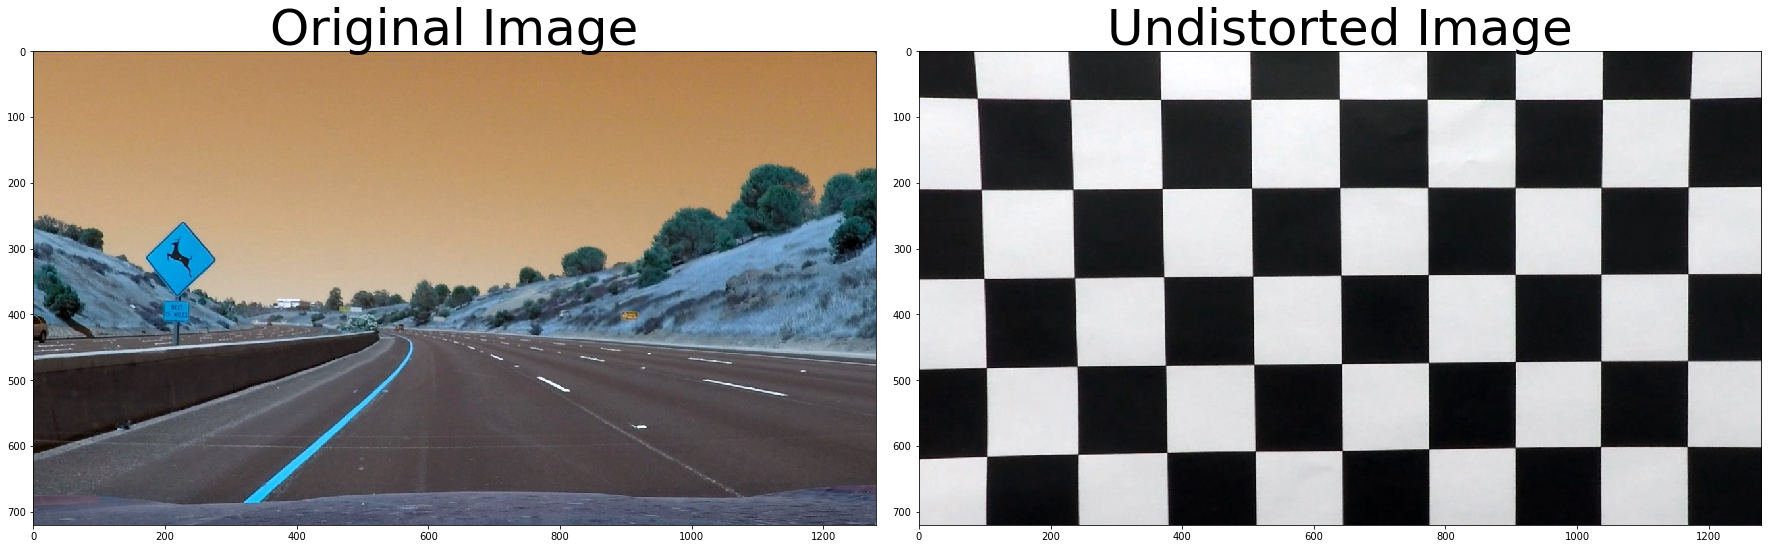

In [35]:
# This function does all the work required to undistort images
def cal_undistort(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(img, cameraMatrix, calibrate, None, cameraMatrix)
    return undist


# All the codes below in this block are testing codes for the undistort function

# Read in an image
#test_img = test_imgs[0]
test_img = cv2.imread("test_images/test2.jpg")
test_img = cv2.resize(test_img, (1280, 720))

test_img_chessboard = cv2.imread("camera_cal/calibration1.jpg")


# Jupyter notebook somewhat messed up with the color channel and display the image in BGR
# But the file output is fine
undistorted = cal_undistort(test_img.copy())
cv2.imwrite("output_images/undistortion.jpg",undistorted)
undistorted = cal_undistort(test_img_chessboard.copy())
cv2.imwrite("output_images/undistorted_chessboard.jpg",undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)







## Step 3. Use gradients to create a thresholded binary image.

In [3]:
# filter the image using absolute sobel gradient in either x or y axis
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [4]:
# filter the image using the magnitude of the sobel gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(mag / np.max(mag) * 255)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

In [5]:
# filter the image using the direction of the sobel gradient
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    

In [6]:
def gradient_threshold(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 150))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 150))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(45, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(-1.3, 1.3))

    combined = np.zeros_like(dir_binary)
    # Choosing the pixels that are either chosen by both x and y absolute sobel filter, 
    # or by both magnitude and directional sobel filters
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined



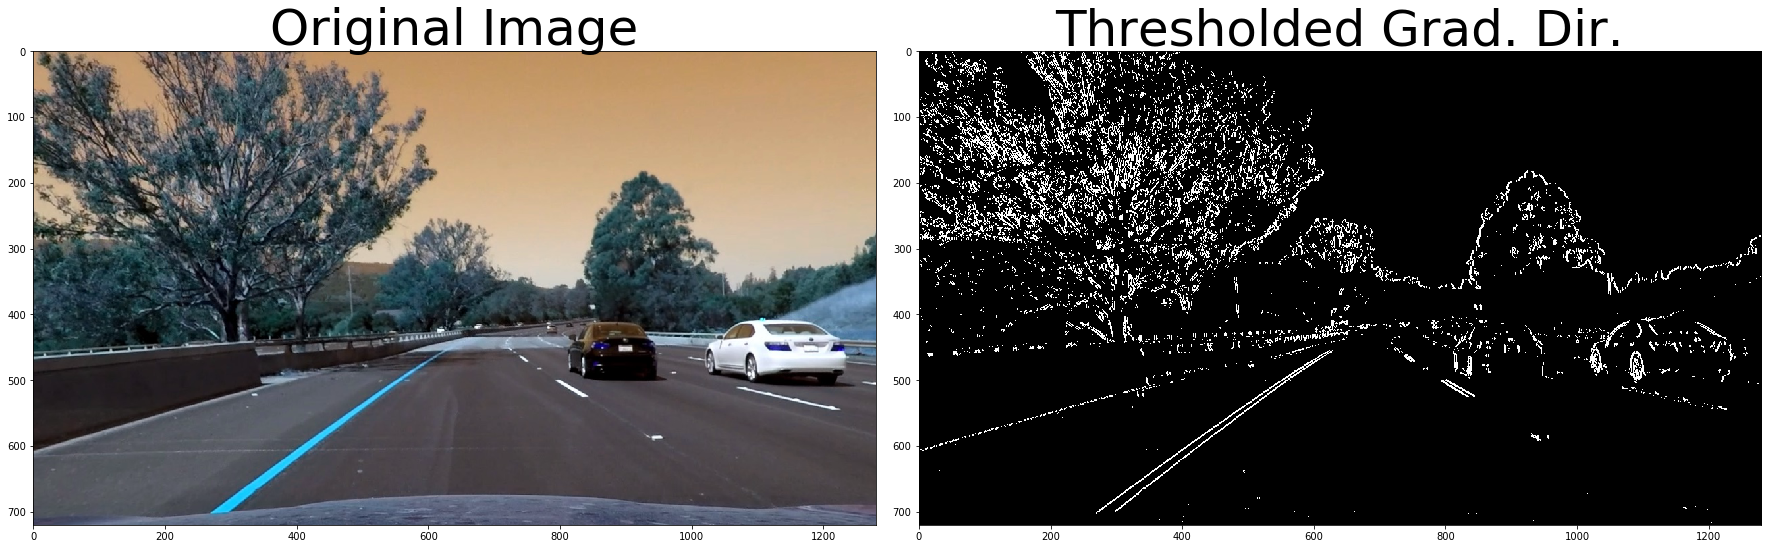

In [7]:
# Testing block for sobel image gradient thresholds

#test_img = cv2.imread("test_images/signs_vehicles_xygrad.png")
test_img = cv2.imread("test_images/test6.jpg") # works on straight lines, test 1, 4, 5 needs to be done in color filter
test_img = cv2.resize(test_img, (1280, 720))
test_img = cal_undistort(test_img.copy()) # need to apply step 2 here


combined = gradient_threshold(test_img)

%matplotlib inline
# Plot the result
# Again, this looks weird, but the result is correct
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Step 4. Use Color Transform to create a thresholded binary image.

In [8]:
def hls_select(img, s_thresh=(0, 255), l_thresh=(0,255), h_thresh=(0,360)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    l = hls[:,:,1]
    h = hls[:,:,0]
    binary_output = np.zeros_like(s)
    binary_output[(s > s_thresh[0]) & (s <= s_thresh[1]) & (l > l_thresh[0]) & (l <= l_thresh[1]) & (h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def color_filters(img):
    img = hls_select(img, s_thresh=(90, 255), l_thresh=(40,255), h_thresh=(0,360))
    return img

True

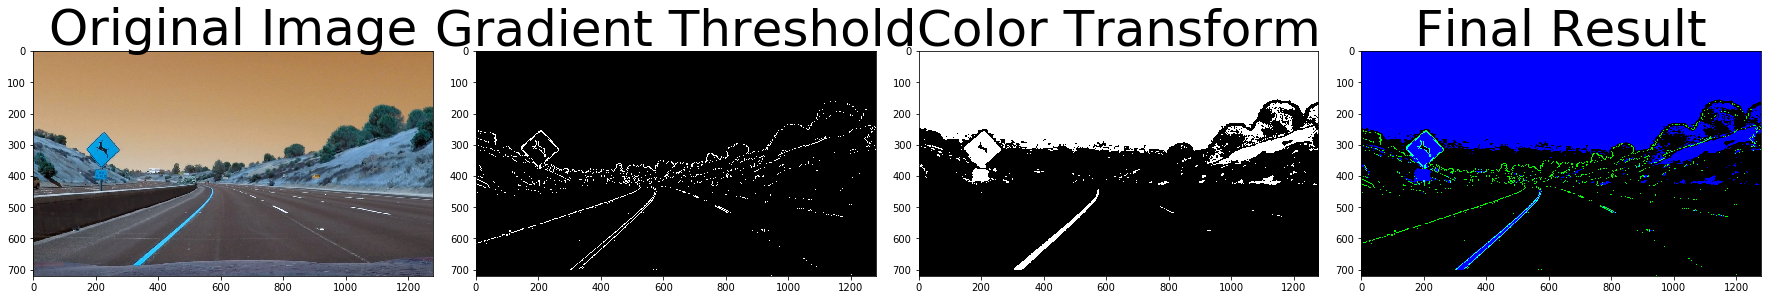

In [42]:
# Test block
# load image
test_img = cv2.imread("test_images/test2.jpg") # works on straight lines, test 1, 4, 5 needs to be done in color filter
test_img = cv2.resize(test_img, (1280, 720))
# apply step 2
test_img2 = cal_undistort(test_img.copy()) # need to apply step 2 here

# apply step 3
gradient_thresholded = gradient_threshold(test_img2)

# apply color filters
color_filtered = color_filters(test_img2)

# final result
# displays lines selected by the thresholds separately
color_binary = np.dstack(( np.zeros_like(gradient_thresholded), gradient_thresholded, color_filtered))
# displays the final result in black and white
combined_binary = np.zeros_like(gradient_thresholded)
combined_binary[(gradient_thresholded == 1) | (color_filtered == 1)] = 1


%matplotlib inline
# Plot the result
# Again, this looks weird, but the result is correct
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradient_thresholded, cmap='gray')
ax2.set_title('Gradient Threshold', fontsize=50)
ax3.imshow(color_filtered, cmap='gray')
ax3.set_title('Color Transform', fontsize=50)
ax4.imshow(color_binary, cmap='gray')
ax4.set_title('Final Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite("output_images/thresholded.jpg", color_binary)

True

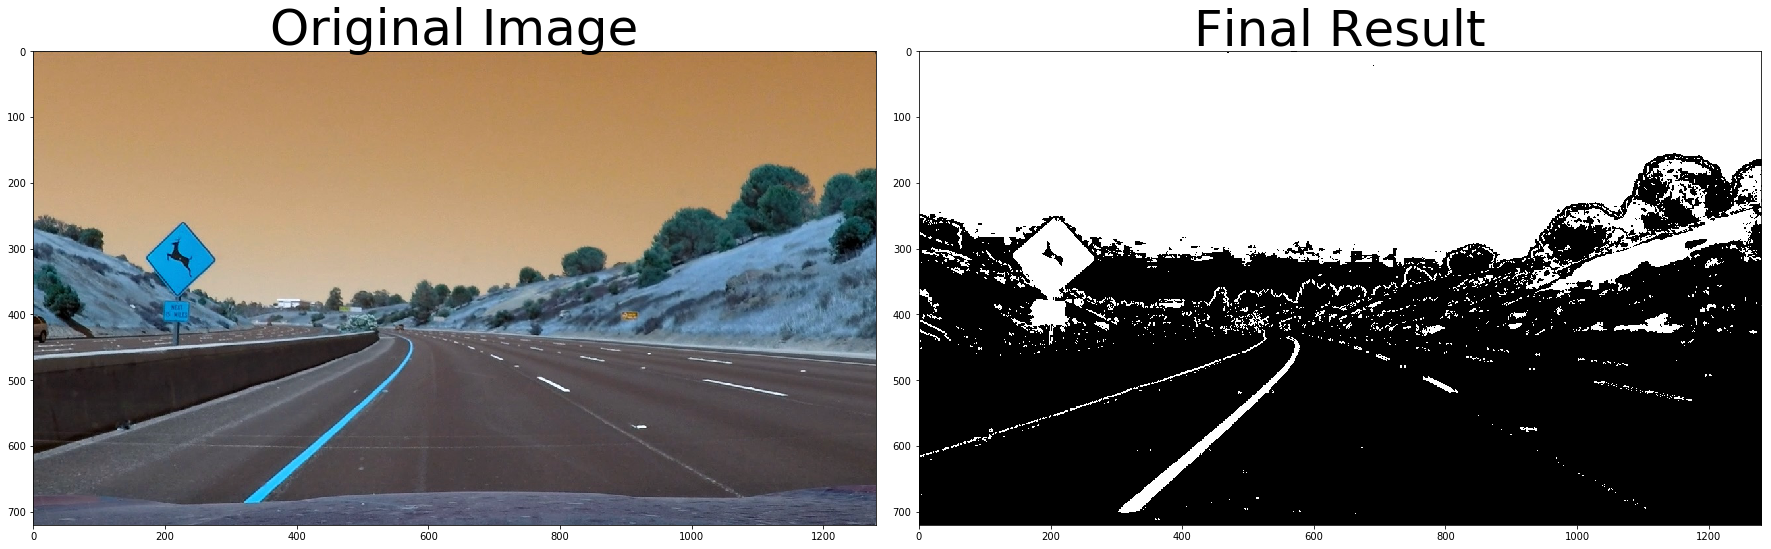

In [41]:

# More concised version 
%matplotlib inline
# Plot the result
# Again, this looks weird, but the result is correct
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Final Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Step 5. Perspective Transform

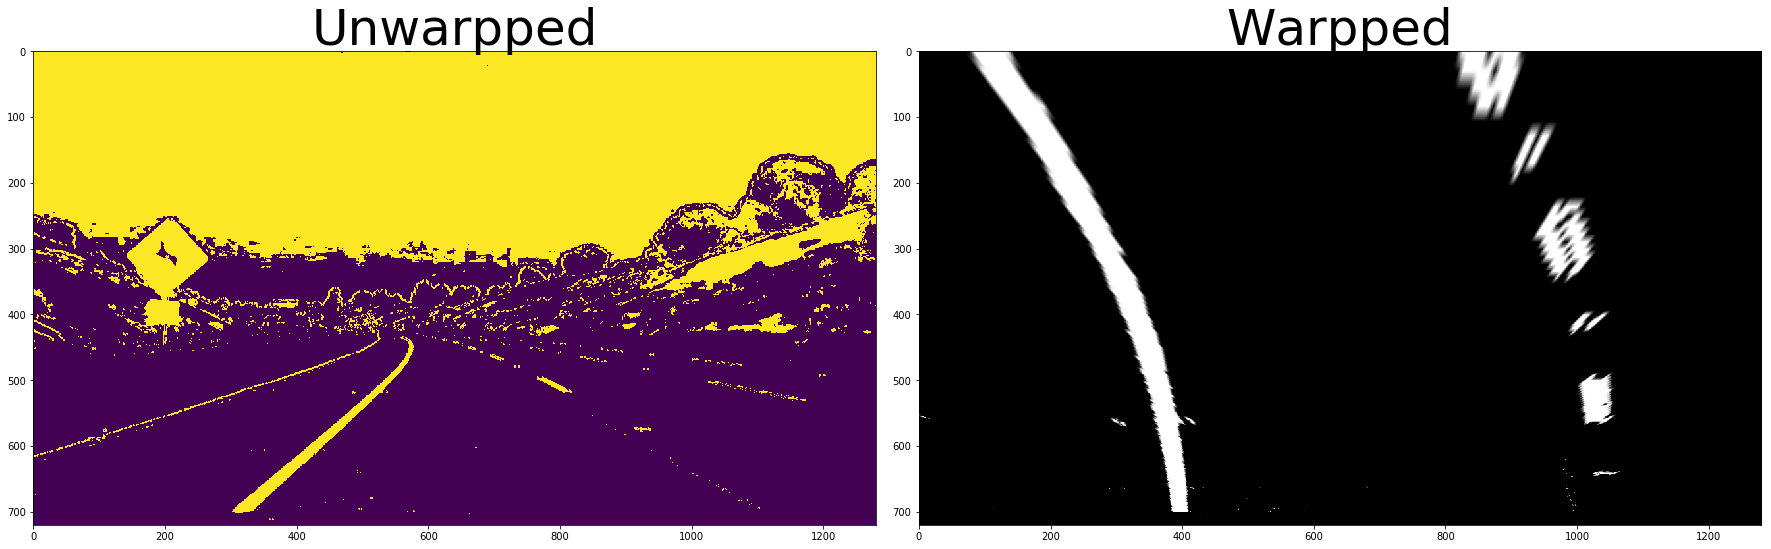

In [11]:
# four points for perspective transformation
# (220, 700)  (600, 450) (675,450) (1050,700)

src = np.float32([[220,700],[600,450],[675,450],[1050,700]])
dst = np.float32([[325,700],[325,0],[950,0],[950,700]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(combined_binary, M, (test_img.shape[1], test_img.shape[0]))

%matplotlib inline
# Plot the result
# Again, this looks weird, but the result is correct
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary)
ax1.set_title('Unwarpped', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warpped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





## Step 6: Finding the Lines

In [12]:
def histogram_lanes(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)

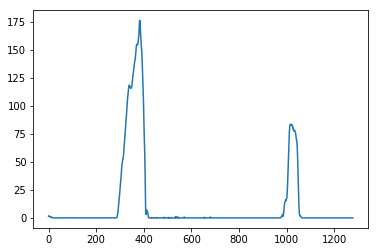

In [13]:
histogram_lanes(binary_warped)

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [15]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def find_lanes_from_binary_image(img, nwindows = 9, window_margin = 100, min_pixel = 50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = nwindows
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = window_margin
    # Set minimum number of pixels found to recenter window
    minpix = min_pixel
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,0,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    plt.imshow(out_img)
    
    return left_lane_inds, right_lane_inds, left_fit, right_fit,leftx, rightx, lefty, righty, out_img, nonzero

In [16]:
find_lanes_from_binary_image(img, nwindows = 9, window_margin = 100, min_pixel = 50)

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/matrix.cpp:1052: error: (-215) cn <= 4 in function scalarToRawData


(720, 0)

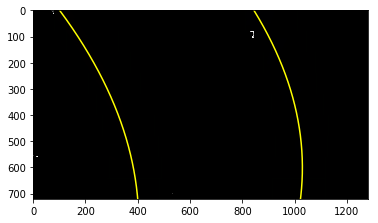

In [17]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

out_img[ploty.astype(int), left_fitx.astype(int)] = [0,255,255]
out_img[ploty.astype(int), right_fitx.astype(int)] = [0,255,255]
plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
cv2.imwrite("output_images/fit_polynomial.jpg", out_img)
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [18]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [ ]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print(left_fit)
print(right_fit)

## Calculate Curvature

In [ ]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff_left =  2.23273739e-04 # arbitrary quadratic coefficient
quadratic_coeff_right =  7.98037109e-04
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff_left + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff_right + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


## Plot the lanes back to the image

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(test_img, 1, newwarp, 0.3, 0)
cv2.imwrite("output_images/plotback.jpg",result)
plt.imshow(result)

## Try to process the lane finding in one block with concise code using the class


In [19]:
def preprocess(img, M):
    '''
    Convert the source image to perspective transformed binary lane maps
    '''
    test_img2 = cal_undistort(img.copy()) # need to apply step 2 here
    gradient_thresholded = gradient_threshold(test_img2)
    color_filtered = color_filters(test_img2)
    combined_binary = np.zeros_like(gradient_thresholded)
    combined_binary[(gradient_thresholded == 1) | (color_filtered == 1)] = 1
    binary_warped = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))
    return binary_warped

In [20]:
import random
def find_lanes(source_img, img, Minv, reuse = False, left_lane = None, right_lane = None):
    '''
    Find and calculate the lane curvature, and draw the lane area back to the source image
    '''
    # TODO: Store the line parameters into the Line class
    
    
    # Assuming you have created a warped binary image called "img"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # If we are reusing previous results
    if reuse:
        left_fit = left_lane.current_fit
        right_fit =  right_lane.current_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    else:
        
        # If we are not reusing previous results, start from scratch
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    
    

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) * 255
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(source_img, 1, newwarp, 0.3, 0)
    

    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, np.random.choice(leftx,len(ploty))*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, np.random.choice(rightx,len(ploty))*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # negative = right, positive = left
    offset = leftx_base - midpoint + rightx_base - midpoint
    if offset < 0:
        direction = "right"
    else:
        direction = "left"
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Curvature = {}m'.format(int(min(left_curverad,right_curverad))),(10,50), font, 1,(255,255,255),2)
    cv2.putText(result,'Car is {}m {} of center'.format(int(abs(offset * xm_per_pix * 100)) / 100, direction),(10,150), font, 1,(255,255,255),2)
    
    # store the result into the Line class
    if not left_lane.detected:
        left_lane.detected = True
    if not right_lane.detected:
        right_lane.detected = True
        
    # store the left lane
    left_lane.current_fit = left_fit
    left_lane.radius_of_curvature = left_curverad
    left_lane.line_base_pos = (midpoint - leftx_base) * xm_per_pix
    left_lane.allx = leftx
    left_lane.ally = lefty
    

    # store the right lane
    right_lane.current_fit = right_fit
    right_lane.radius_of_curvature = right_curverad
    right_lane.line_base_pos = (rightx_base - midpoint) * xm_per_pix
    right_lane.allx = rightx
    right_lane.ally = righty
    
    
    return result, left_lane, right_lane
    

In [21]:
def process_image(img, reuse = True):
    cv2.imwrite("101.jpg",img)
    if img.shape != (720, 1280, 3):
        img = cv2.resize(img, (1280, 720))
    after_preprocess = preprocess(img,M)
    return find_lanes(img, after_preprocess, Minv, reuse = reuse, left_lane = left_lane, right_lane = right_lane)[0]

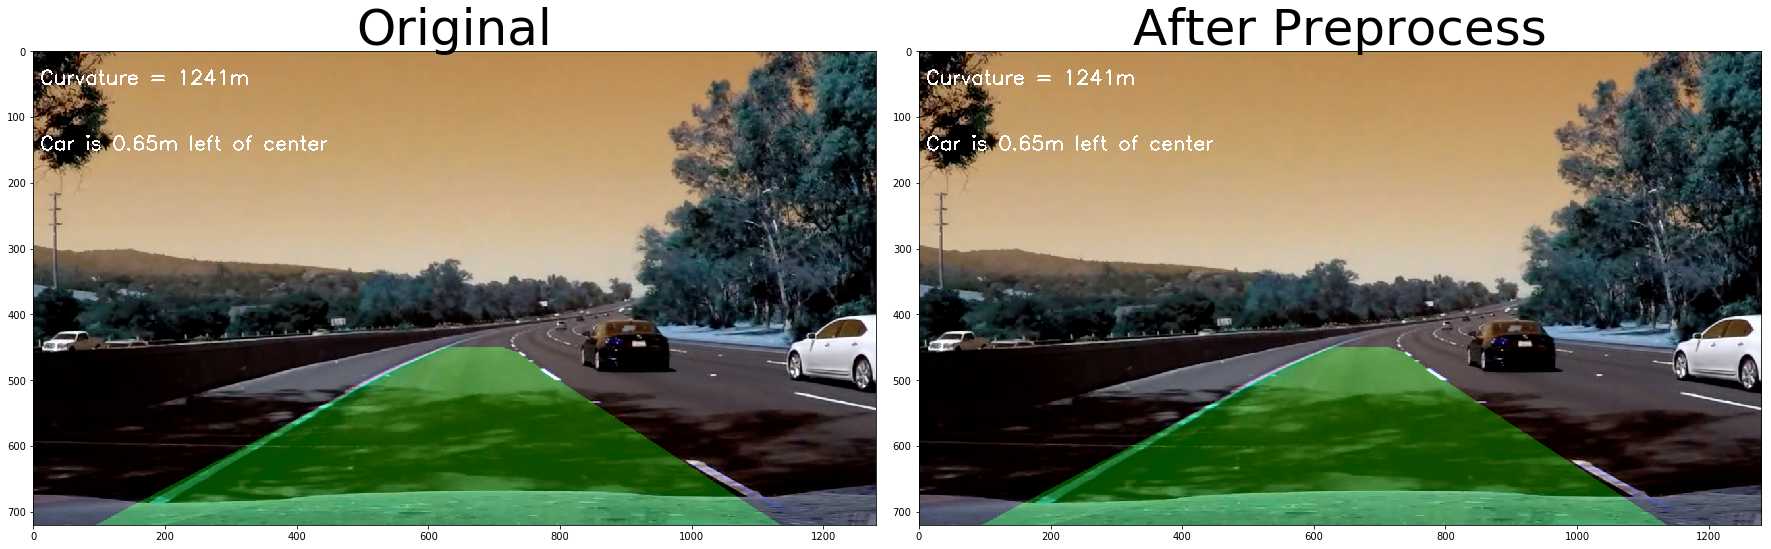

In [31]:
import os
# get the perspective transform matricies
src = np.float32([[220,700],[600,450],[675,450],[1050,700]])
dst = np.float32([[325,700],[325,0],[950,0],[950,700]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# load image   
image_paths = os.listdir("test_images")
in_images = []
out_images = []
left_lane = Line()
right_lane = Line()
images = glob.glob('test_images/*.jpg')
images.extend(glob.glob('test_images/*.png'))
for img_path in images:
    img = cv2.imread(img_path)
    file_path = img_path.split("/")[1]
    in_images.append((file_path,img))
    out_img = process_image(img, reuse = False)
    out_images.append(out_img)
    
for (path,_), img in zip(in_images, out_images):
    cv2.imwrite("output_images/"+path, img)

%matplotlib inline
# Plot the result
# Again, this looks weird, but the result is correct
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)

ax2.imshow(out_img, cmap='gray')
ax2.set_title('After Preprocess', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

# # get the perspective transform matricies
src = np.float32([[220,700],[600,450],[675,450],[1050,700]])
dst = np.float32([[325,700],[325,0],[950,0],[950,700]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
left_lane = Line()
right_lane = Line()
# Load the video
yellow_output = 'output_video_.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4').subclip(1,6)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

IndexError: list index out of range